# Models for Exchange Rate Forecasting

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.tools.eval_measures as evl
import statsmodels.stats.diagnostic as tst
from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 1. Import Data

In [2]:
df = pd.read_excel(r'C:\Users\Moses\Desktop\US_UK_rawdata.xls', header=28)

In [3]:
df.set_index('observation_date',inplace=True)

In [4]:
df.head()

,r_lb_us,r_lb_uk,r_sb_us,r_sb_uk,pi_us,pi_uk,y_us,y_uk,r_si_us,r_si_uk,m1_us,m1_uk,m3_us,m3_uk,m0_us,m0_uk,tb_us,tb_uk,s_us_uk
observation_date,,,,,,,,,,,,,,,,,,,
1986-12-01,7.11,10.98,5.53,10.6646,1.09790,3.75000,55.577291,89.227954,6.04,11.40421,7.247000e+11,88610000000,2.728000e+12,174191000000,232.330,15016.31,-1.202510e+10,-4.070000e+08,1.4393
1987-01-01,7.08,10.27,5.43,10.5618,1.45985,3.95010,55.406992,87.577382,5.87,11.10085,7.302000e+11,96116000000,2.743900e+12,262968000000,233.828,15010.34,-1.482110e+10,-1.343000e+09,1.5054
1987-02-01,7.25,9.97,5.59,10.1969,2.10430,3.93375,56.132081,90.393063,6.10,10.89219,7.307000e+11,97213000000,2.747500e+12,266218000000,236.149,14973.51,-1.227030e+10,-5.450000e+08,1.5280
1987-03-01,7.25,9.11,5.59,9.3157,3.03309,4.03309,56.205176,90.004693,6.17,10.01420,7.338000e+11,99217000000,2.753700e+12,270734000000,235.280,15053.14,-1.209110e+10,-9.610000e+08,1.5923
1987-04-01,8.02,9.14,5.64,8.6988,3.77532,4.19652,56.559700,89.227954,6.52,9.83097,7.439000e+11,100700000000,2.767700e+12,274944000000,237.849,15071.06,-1.310020e+10,-1.008000e+09,1.6313


### 1.1 Check Data Unit

In [5]:
df.m0_us=df.m0_us*1000000000
df.m0_uk=df.m0_uk*1000000

In [6]:
df.describe()
#summary=df.describe()
#summary.T[['count','mean','std','min','max']].to_excel("output.xlsx")

,r_lb_us,r_lb_uk,r_sb_us,r_sb_uk,pi_us,pi_uk,y_us,y_uk,r_si_us,r_si_uk,m1_us,m1_uk,m3_us,m3_uk,m0_us,m0_uk,tb_us,tb_uk,s_us_uk
count,402.000000,402.000000,402.000000,367.000000,402.000000,402.000000,402.000000,402.000000,401.000000,402.000000,4.020000e+02,4.020000e+02,4.020000e+02,4.020000e+02,3.960000e+02,3.630000e+02,4.020000e+02,4.020000e+02,402.000000
mean,4.837488,5.314603,3.057587,4.989827,2.588952,2.723020,85.193636,101.818010,3.513342,5.013614,1.688423e+12,7.394019e+11,7.003352e+12,1.419701e+12,1.411491e+12,1.045184e+11,-3.996563e+10,-5.283091e+09,1.607533
std,2.213734,3.029577,2.449816,3.835579,1.332158,1.738643,15.158693,5.291787,2.658481,4.014691,9.548704e+11,5.381894e+11,3.789469e+12,8.765433e+11,1.323950e+12,1.299323e+11,2.443521e+10,3.850361e+09,0.182541
min,0.660000,0.274300,0.010000,0.010600,-2.097160,0.199800,55.406992,77.376939,0.110000,0.281190,7.247000e+11,8.861000e+10,2.728000e+12,1.741910e+11,2.323300e+11,1.497351e+10,-8.896300e+10,-1.513763e+10,1.216000
25%,2.832500,2.783825,0.510000,0.511850,1.726690,1.638090,70.557133,97.869181,1.050000,0.790000,1.081850e+12,2.301768e+11,3.505450e+12,5.634515e+11,4.415465e+11,2.124390e+10,-6.248225e+10,-8.607250e+09,1.506250
50%,4.650000,4.825050,2.965000,4.938600,2.602755,2.314020,89.989322,102.056642,3.220000,5.078385,1.296800e+12,5.747300e+11,6.052550e+12,1.123958e+12,7.393915e+11,3.530282e+10,-4.283950e+10,-3.811500e+09,1.598200
75%,6.490000,7.877525,5.030000,6.536200,3.309140,3.073018,97.938667,106.405934,5.580000,6.702285,2.193125e+12,1.102694e+12,9.710500e+12,2.348692e+12,2.626178e+12,1.861199e+11,-1.352525e+10,-1.791750e+09,1.696400
max,9.520000,12.740000,8.820000,14.620000,6.289810,9.248550,106.185865,110.654080,10.090000,15.316760,5.031700e+12,2.019695e+12,1.787050e+13,3.150844e+12,4.099142e+12,4.809100e+11,-1.888500e+09,4.860000e+08,2.070100


### 1.2 Check Missing Data

In [7]:
df.isnull().sum()

r_lb_us     0
r_lb_uk     0
r_sb_us     0
r_sb_uk    35
pi_us       0
pi_uk       0
y_us        0
y_uk        0
r_si_us     1
r_si_uk     0
m1_us       0
m1_uk       0
m3_us       0
m3_uk       0
m0_us       6
m0_uk      39
tb_us       0
tb_uk       0
s_us_uk     0
dtype: int64

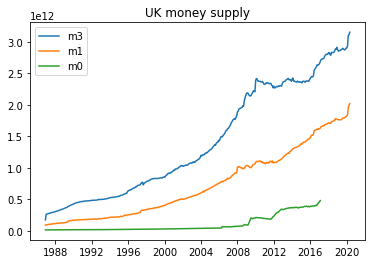

In [8]:
plt.plot(df.m3_uk,label='m3')
plt.plot(df.m1_uk,label='m1')
plt.plot(df.m0_uk,label='m0')
#plt.plot(df.m0_uk.iloc[:363],label='m0')
#plt.plot(df.m0_uk.iloc[363:],'r',label='m0_hat')
plt.legend(loc='best')
plt.title('UK money supply')
plt.show()

In [9]:
ratio_m1_m0_uk=(df.m1_uk/df.m0_uk).rolling(48,min_periods=1).mean()
ratio_m3_m0_uk=(df.m3_uk/df.m0_uk).rolling(48,min_periods=1).mean()
df.m0_uk.fillna((df.m1_uk/ratio_m1_m0_uk+df.m3_uk/ratio_m3_m0_uk)/2,inplace=True)

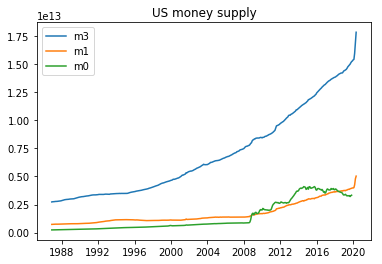

In [10]:
plt.plot(df.m3_us,label='m3')
plt.plot(df.m1_us,label='m1')
plt.plot(df.m0_us,label='m0')
#plt.plot(df.m0_us.iloc[:396],label='m0')
#plt.plot(df.m0_us.iloc[396:],'r',label='m0_hat')
plt.legend(loc='best')
plt.title('US money supply')
plt.show()

In [11]:
ratio_m1_m0_us=(df.m1_us/df.m0_us).rolling(12,min_periods=1).mean()
ratio_m3_m0_us=(df.m3_us/df.m0_us).rolling(12,min_periods=1).mean()
df.m0_us.fillna((df.m1_us/ratio_m1_m0_us+df.m3_us/ratio_m3_m0_us)/2,inplace=True)

In [12]:
df.r_si_us.fillna(method='ffill',inplace=True)

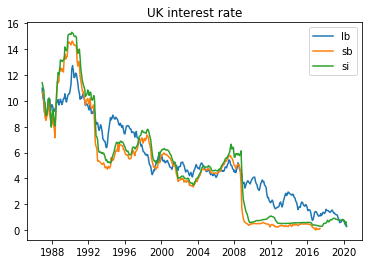

In [13]:
plt.plot(df.r_lb_uk,label='lb')
plt.plot(df.r_sb_uk,label='sb')
#plt.plot(df.r_sb_uk.iloc[:367],label='sb')
#plt.plot(df.r_sb_uk.iloc[367:],'r',label='sb_hat')
plt.plot(df.r_si_uk,label='si')
plt.legend(loc='best')
plt.title('UK interest rate')
plt.show()

In [14]:
delta_si_sb_uk=(df.r_si_uk-df.r_sb_uk).rolling(36,min_periods=1).mean()
df.r_sb_uk.fillna((df.r_si_uk-delta_si_sb_uk),inplace=True)

In [15]:
df['pi_e_cpi_us']=df.pi_us.shift(-12)
df['pi_e_cpi_uk']=df.pi_uk.shift(-12)
df.at['2019-06-01','pi_e_cpi_us']=0.64573
df.at['2019-06-01','pi_e_cpi_uk']=0.83411
df.pi_e_cpi_us.fillna(df.pi_e_cpi_us.rolling(12,min_periods=1).mean(),inplace=True)
df.pi_e_cpi_uk.fillna(df.pi_e_cpi_uk.rolling(12,min_periods=1).mean(),inplace=True)

In [16]:
df.isnull().sum()

r_lb_us        0
r_lb_uk        0
r_sb_us        0
r_sb_uk        0
pi_us          0
pi_uk          0
y_us           0
y_uk           0
r_si_us        0
r_si_uk        0
m1_us          0
m1_uk          0
m3_us          0
m3_uk          0
m0_us          0
m0_uk          0
tb_us          0
tb_uk          0
s_us_uk        0
pi_e_cpi_us    0
pi_e_cpi_uk    0
dtype: int64

### 1.3 Data Summary and Transformation (due to potential outlier)

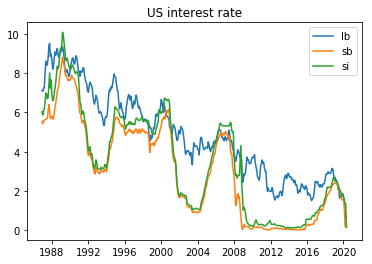

In [17]:
plt.plot(df.r_lb_us,label='lb')
plt.plot(df.r_sb_us,label='sb')
plt.plot(df.r_si_us,label='si')
plt.legend(loc='best')
plt.title('US interest rate')
plt.show()

In [18]:
df[['r_lb_us','r_sb_us','r_si_us','m3_us','m1_us','m0_us']].corr()

,r_lb_us,r_sb_us,r_si_us,m3_us,m1_us,m0_us
r_lb_us,1.000000,0.893175,0.886507,-0.883719,-0.808526,-0.829636
r_sb_us,0.893175,1.000000,0.990170,-0.738774,-0.657795,-0.736454
r_si_us,0.886507,0.990170,1.000000,-0.731816,-0.661766,-0.737461
m3_us,-0.883719,-0.738774,-0.731816,1.000000,0.973723,0.950014
m1_us,-0.808526,-0.657795,-0.661766,0.973723,1.000000,0.948765
m0_us,-0.829636,-0.736454,-0.737461,0.950014,0.948765,1.000000


In [19]:
df[['r_lb_uk','r_sb_uk','r_si_uk','m3_uk','m1_uk','m0_uk']].corr()

,r_lb_uk,r_sb_uk,r_si_uk,m3_uk,m1_uk,m0_uk
r_lb_uk,1.000000,0.932364,0.933533,-0.912036,-0.904300,-0.797342
r_sb_uk,0.932364,1.000000,0.996541,-0.860070,-0.827616,-0.743570
r_si_uk,0.933533,0.996541,1.000000,-0.856180,-0.827544,-0.747920
m3_uk,-0.912036,-0.860070,-0.856180,1.000000,0.984771,0.903352
m1_uk,-0.904300,-0.827616,-0.827544,0.984771,1.000000,0.938703
m0_uk,-0.797342,-0.743570,-0.747920,0.903352,0.938703,1.000000


In [20]:
df['log_s_us_uk'] = np.log(df.s_us_uk)
df['log_m0']=np.log(df.m0_us/df.m0_uk)
df['log_m1']=np.log(df.m1_us/df.m1_uk)
df['log_m3']=np.log(df.m3_us/df.m3_uk)
df['log_y']=np.log(df.y_us/df.y_uk)
df['r_si']=(df.r_si_us-df.r_si_uk)/100
df['r_sb']=(df.r_sb_us-df.r_sb_uk)/100
df['pi']=(df.pi_us-df.pi_uk)/100
df['pi_e_cpi']=(df.pi_e_cpi_us-df.pi_e_cpi_uk)/100
df['pi_e_lb']=(df.r_lb_us-df.r_lb_uk)/100

### 1.4 Features Selection and Train/Test Split

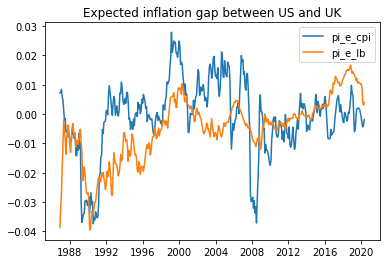

,pi_e_cpi,pi_e_lb
pi_e_cpi,1.000000,0.421248
pi_e_lb,0.421248,1.000000


In [21]:
plt.plot(df.pi_e_cpi,label='pi_e_cpi')
plt.plot(df.pi_e_lb,label='pi_e_lb')
plt.legend(loc='best')
plt.title('Expected inflation gap between US and UK')
plt.show()
df[['pi_e_cpi','pi_e_lb']].corr()

In [22]:
#df[['log_s_us_uk','log_m0','log_m1','log_m3','log_y','r_si','r_sb','pi','pi_e_cpi','pi_e_lb','tb_us','tb_uk']].describe()
summary2=df[['log_s_us_uk','log_m0','log_m1','log_m3','log_y','r_si','r_sb','pi','pi_e_cpi','pi_e_lb','tb_us','tb_uk']].describe()
summary2.T[['count','mean','std','min','max']].to_excel("output2.xlsx")

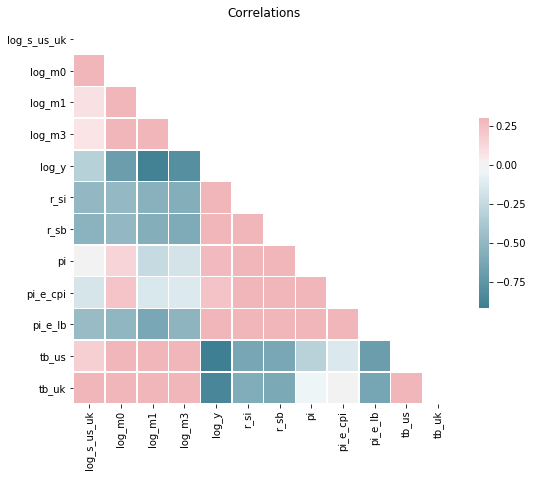

,log_s_us_uk,log_m0,log_m1,log_m3,log_y,r_si,r_sb,pi,pi_e_cpi,pi_e_lb,tb_us,tb_uk
log_s_us_uk,1.000000,0.411286,0.077493,0.067593,-0.312814,-0.492059,-0.536392,-0.030190,-0.161986,-0.470472,0.177904,0.386844
log_m0,0.411286,1.000000,0.507977,0.415168,-0.695310,-0.485035,-0.495186,0.145663,0.227398,-0.506388,0.690134,0.872104
log_m1,0.077493,0.507977,1.000000,0.928318,-0.895775,-0.551083,-0.563403,-0.240031,-0.142744,-0.621853,0.868667,0.718001
log_m3,0.067593,0.415168,0.928318,1.000000,-0.802287,-0.564548,-0.596769,-0.178496,-0.127433,-0.523970,0.727313,0.613574
log_y,-0.312814,-0.695310,-0.895775,-0.802287,1.000000,0.711774,0.730284,0.274489,0.237115,0.775999,-0.922782,-0.861382
r_si,-0.492059,-0.485035,-0.551083,-0.564548,0.711774,1.000000,0.983607,0.454298,0.385720,0.855479,-0.628718,-0.586648
r_sb,-0.536392,-0.495186,-0.563403,-0.596769,0.730284,0.983607,1.000000,0.407132,0.409258,0.837965,-0.625525,-0.603350
pi,-0.030190,0.145663,-0.240031,-0.178496,0.274489,0.454298,0.407132,1.000000,0.348150,0.473642,-0.304052,-0.040238
pi_e_cpi,-0.161986,0.227398,-0.142744,-0.127433,0.237115,0.385720,0.409258,0.348150,1.000000,0.421248,-0.132702,0.009176
pi_e_lb,-0.470472,-0.506388,-0.621853,-0.523970,0.775999,0.855479,0.837965,0.473642,0.421248,1.000000,-0.694581,-0.640245


In [23]:
corr=df[['log_s_us_uk','log_m0','log_m1','log_m3','log_y','r_si','r_sb','pi','pi_e_cpi','pi_e_lb','tb_us','tb_uk']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations')
plt.show()
corr

In [24]:
train=df[['log_s_us_uk','log_m0','log_y','r_sb','pi_e_lb','tb_us','tb_uk']].iloc[:302]
test=df[['log_s_us_uk','log_m0','log_y','r_sb','pi_e_lb','tb_us','tb_uk']].iloc[302:]

## 2. Structural Model Selection

### 2.1 OLS 

In [25]:
result = smf.ols(formula="log_s_us_uk ~ log_m0+log_y+r_sb+pi_e_lb+tb_us+tb_uk", data=train).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            log_s_us_uk   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     32.53
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           5.29e-30
Time:                        22:29:55   Log-Likelihood:                 369.67
No. Observations:                 302   AIC:                            -725.3
Df Residuals:                     295   BIC:                            -699.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5740      0.116      4.935      0.0

In [26]:
y_train, X_train = train.iloc[:,0], train.iloc[:,1:]
y_test, X_test = test.iloc[:,0], test.iloc[:,1:]
mod_ols=sm.OLS(y_train, X_train)
res_ols=mod_ols.fit()
print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            log_s_us_uk   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2321.
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          1.40e-245
Time:                        22:29:55   Log-Likelihood:                 357.69
No. Observations:                 302   AIC:                            -703.4
Df Residuals:                     296   BIC:                            -681.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_m0         0.0640      0.010      6.316      0.0

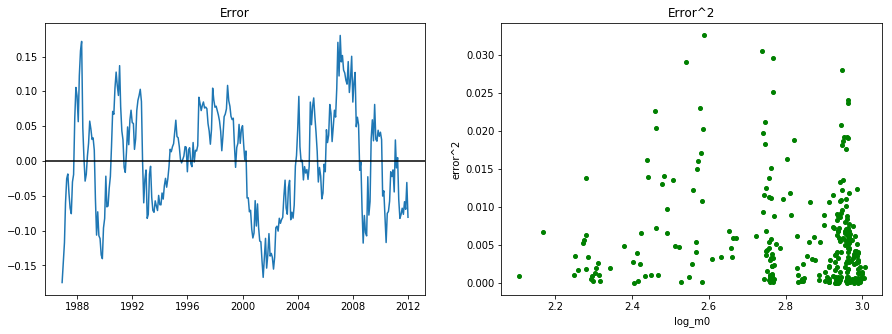

In [27]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(res_ols.resid,label='error')
plt.axhline(y=0,color='k')
plt.title('Error')
plt.subplot(122)
plt.plot(train.log_m0,res_ols.resid**2,'o',color='g',markersize=4,label='error^2')
plt.xlabel("log_m0")
plt.ylabel("error^2")
plt.title('Error^2')
plt.show()

In [28]:
#import patsy
#f = "log_s_us_uk ~ log_m0+log_y+r_sb+pi_e_lb+tb_us+tb_uk"
#y_train, X_train = patsy.dmatrices(f, train, return_type='matrix')
#y_test,X_test=patsy.dmatrices(f, test, return_type='matrix')

In [29]:
t_train=np.array(df.index[:302])
t_test=np.array(df.index[302:])
t=np.array(df.index)

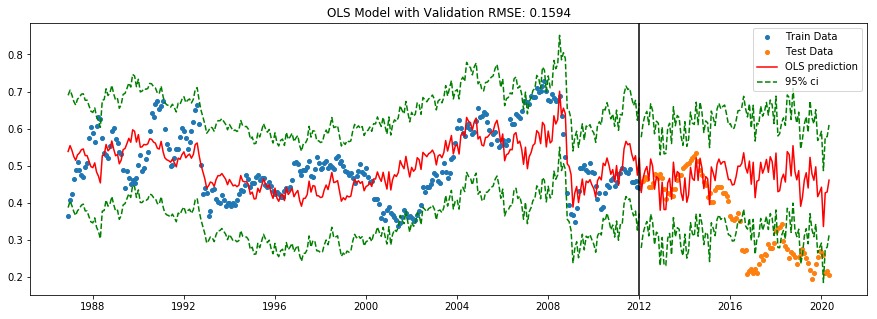

In [30]:
y_pre_train=res_ols.predict(X_train)
y_pre_test=res_ols.predict(X_test)
prstd, iv_l, iv_u = wls_prediction_std(res_ols)
prstd2, iv_l2, iv_u2 = wls_prediction_std(res_ols, exog= X_test)
rmse_m_ols=evl.rmse(y_train, y_pre_train)
res_ols.mrmse = rmse_m_ols
rmse_p_ols=evl.rmse(y_test, y_pre_test)
res_ols.prmse = rmse_p_ols
plt.figure(figsize=[15,5])
plt.plot(t_train, y_train, 'o', markersize=4, label="Train Data")
plt.plot(t_test, y_test, 'o', markersize=4, label="Test Data")
plt.plot(np.hstack((t_train, t_test)),np.hstack((y_pre_train, y_pre_test)), 'r', label="OLS prediction")
plt.plot(t_train, iv_u, 'g--',label='95% ci')
plt.plot(t_train, iv_l, 'g--')
plt.plot(t_test, iv_u2, 'g--')
plt.plot(t_test, iv_l2, 'g--')
plt.axvline('2012-01-01',color='k')
plt.legend(loc="best")
plt.title('OLS Model with Validation RMSE: %.4f'%rmse_p_ols)
plt.show()

In [31]:
error_ols=res_ols.resid
lm_ols, lm_pvalue_ols, fvalue_ols, f_pvalue_ols=tst.het_breuschpagan(error_ols,X_train)
print('Heteroskedasticity (BP-test p value):%.4f' %lm_pvalue_ols)
print('Reject H0, Het.')

Heteroskedasticity (BP-test p value):0.0000
Reject H0, Het.


In [32]:
error_ols_fit = sm.OLS(error_ols[1:], np.array(error_ols[:-1])).fit()
#print(error_fit.tvalues[0])
print('Auto-correlated Errors (AR1, t-test p value):%.4f' %error_ols_fit.pvalues[0])
rho_ols=error_ols_fit.params[0]
print('Reject H0, AR1:', rho_ols)

Auto-correlated Errors (AR1, t-test p value):0.0000
Reject H0, AR1: 0.8968433335470182


### 2.2 Auto-correlated Errors - GLSAR or GLS

In [33]:
mod_glsar = sm.GLSAR(y_train, X_train, 1)
res_glsar = mod_glsar.iterative_fit(100)
print(res_glsar.summary())

                           GLSAR Regression Results                           
Dep. Variable:            log_s_us_uk   R-squared:                       0.331
Model:                          GLSAR   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     24.35
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           2.11e-23
Time:                        22:29:57   Log-Likelihood:                 674.40
No. Observations:                 301   AIC:                            -1337.
Df Residuals:                     295   BIC:                            -1315.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_m0         0.1064      0.016      6.739      0.0

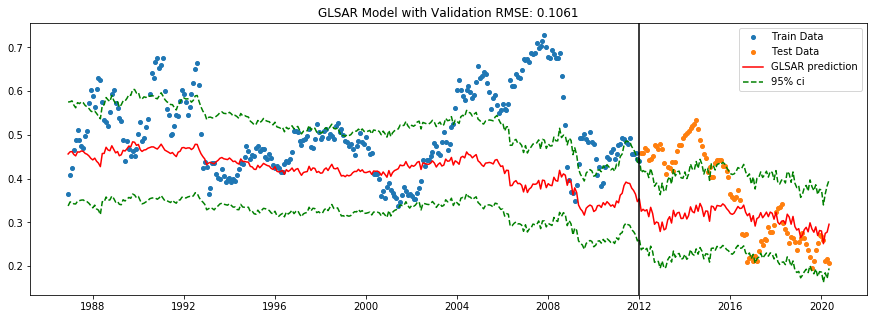

In [34]:
y_pre_train_glsar=res_glsar.predict(X_train)
y_pre_test_glsar=res_glsar.predict(X_test)
rmse_m_glsar=evl.rmse(y_train, y_pre_train_glsar)
res_glsar.mrmse = rmse_m_glsar
rmse_p_glsar=evl.rmse(y_test, y_pre_test_glsar)
res_glsar.prmse = rmse_p_glsar
frame_glsar=res_glsar.get_prediction(np.vstack((X_train,X_test))).summary_frame(alpha=0.05)
plt.figure(figsize=[15,5])
plt.plot(t_train, y_train, 'o', markersize=4, label="Train Data")
plt.plot(t_test, y_test, 'o', markersize=4, label="Test Data")
plt.plot(np.hstack((t_train, t_test)),np.hstack((y_pre_train_glsar, y_pre_test_glsar)), 'r', label="GLSAR prediction")
plt.plot(t, frame_glsar.obs_ci_upper, 'g--',label='95% ci')
plt.plot(t, frame_glsar.obs_ci_lower, 'g--',label='_nolegend_')
plt.axvline('2012-01-01',color='k')
plt.legend(loc="best")
plt.title('GLSAR Model with Validation RMSE: %.4f'%rmse_p_glsar)
plt.show()

In [35]:
error_glsar=res_glsar.resid
lm_glsar, lm_pvalue_glsar, fvalue_glsar, f_pvalue_glsar=tst.het_breuschpagan(error_glsar,X_train)
print('Heteroskedasticity (BP-test p value):%.4f' %lm_pvalue_glsar)
print('Reject H0, het.')

Heteroskedasticity (BP-test p value):0.0000
Reject H0, het.


In [36]:
from scipy.linalg import toeplitz
order = toeplitz(range(len(error_ols)))
sigma = rho_ols**order
mod_gls = sm.GLS(y_train, X_train, sigma=sigma)
res_gls = mod_gls.fit()
print(res_gls.summary())

                            GLS Regression Results                            
Dep. Variable:            log_s_us_uk   R-squared:                       0.793
Model:                            GLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     189.5
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           2.95e-98
Time:                        22:29:57   Log-Likelihood:                 665.26
No. Observations:                 302   AIC:                            -1319.
Df Residuals:                     296   BIC:                            -1296.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_m0         0.1340      0.011     12.378      0.0

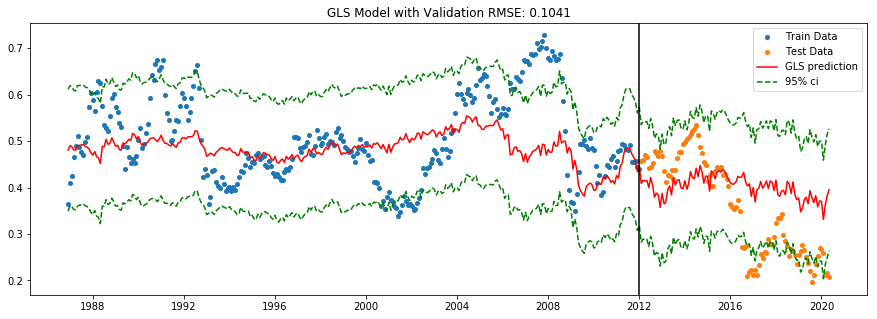

In [37]:
y_pre_train_gls=res_gls.predict(X_train)
y_pre_test_gls=res_gls.predict(X_test)
rmse_m_gls=evl.rmse(y_train, y_pre_train_gls)
res_gls.mrmse = rmse_m_gls
rmse_p_gls=evl.rmse(y_test, y_pre_test_gls)
res_gls.prmse = rmse_p_gls
frame_gls=res_gls.get_prediction(np.vstack((X_train,X_test))).summary_frame(alpha=0.05)
plt.figure(figsize=[15,5])
plt.plot(t_train, y_train, 'o', markersize=4, label="Train Data")
plt.plot(t_test, y_test, 'o', markersize=4, label="Test Data")
plt.plot(np.hstack((t_train, t_test)),np.hstack((y_pre_train_gls, y_pre_test_gls)), 'r', label="GLS prediction")
plt.plot(t, frame_gls.obs_ci_upper, 'g--',label='95% ci')
plt.plot(t, frame_gls.obs_ci_lower, 'g--',label='_nolegend_')
plt.axvline('2012-01-01',color='k')
plt.legend(loc="best")
plt.title('GLS Model with Validation RMSE: %.4f'%rmse_p_gls)
plt.show()

In [38]:
error_gls=res_gls.resid
lm_gls, lm_pvalue_gls, fvalue_gls, f_pvalue_gls=tst.het_breuschpagan(error_gls,X_train)
print('Heteroskedasticity (BP-test p value):%.4f' %lm_pvalue_gls)
print('Reject H0, het.')

Heteroskedasticity (BP-test p value):0.0000
Reject H0, het.


### 2.3 Heteroskedasticity WLS or Robust OLS

In [39]:
print(sm.OLS(res_ols.resid**2,X_train.log_m0).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     212.6
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           8.39e-37
Time:                        22:29:58   Log-Likelihood:                 1095.2
No. Observations:                 302   AIC:                            -2188.
Df Residuals:                     301   BIC:                            -2185.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_m0         0.0019      0.000     14.582      0.0

In [40]:
mod_wls = sm.WLS(y_train, X_train, weights=1./train.log_m0)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:            log_s_us_uk   R-squared:                       0.979
Model:                            WLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2321.
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          1.41e-245
Time:                        22:29:58   Log-Likelihood:                 355.93
No. Observations:                 302   AIC:                            -699.9
Df Residuals:                     296   BIC:                            -677.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_m0         0.0634      0.010      6.221      0.0

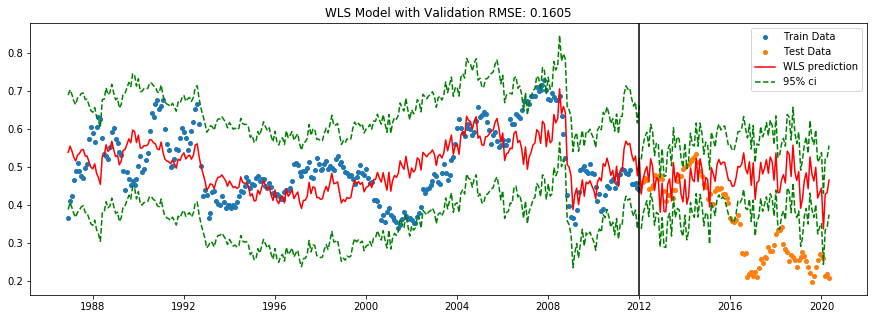

In [41]:
y_pre_train_wls=res_wls.predict(X_train)
y_pre_test_wls=res_wls.predict(X_test)
rmse_m_wls=evl.rmse(y_train, y_pre_train_wls)
res_wls.mrmse = rmse_m_wls
rmse_p_wls=evl.rmse(y_test, y_pre_test_wls)
res_wls.prmse = rmse_p_wls
prstd_wls, iv_l_wls, iv_u_wls = wls_prediction_std(res_wls)
prstd2_wls, iv_l2_wls, iv_u2_wls = wls_prediction_std(res_wls, exog= X_test)
plt.figure(figsize=[15,5])
plt.plot(t_train, y_train, 'o', markersize=4, label="Train Data")
plt.plot(t_test, y_test, 'o', markersize=4, label="Test Data")
plt.plot(np.hstack((t_train, t_test)),np.hstack((y_pre_train_wls, y_pre_test_wls)), 'r', label="WLS prediction")
plt.plot(t_train, iv_u_wls, 'g--',label='95% ci')
plt.plot(t_train, iv_l_wls, 'g--')
plt.plot(t_test, iv_u2_wls, 'g--')
plt.plot(t_test, iv_l2_wls, 'g--')
plt.axvline('2012-01-01',color='k')
plt.legend(loc="best")
plt.title('WLS Model with Validation RMSE: %.4f'%rmse_p_wls)
plt.show()

In [42]:
error_wls=res_wls.resid
lm_wls, lm_pvalue_wls, fvalue_wls, f_pvalue_wls=tst.het_breuschpagan(error_wls,X_train)
print('Heteroskedasticity (BP-test p value):%.4f' %lm_pvalue_wls)
print('Reject H0, het.')
print(lm_ols,lm_glsar,lm_gls,lm_wls)

Heteroskedasticity (BP-test p value):0.0000
Reject H0, het.
133.81448134823714 179.39394244695333 138.02885082159384 134.05995021046814


In [43]:
res_robust_ols=res_ols.get_robustcov_results(cov_type='HC1')
#HC0123
print(res_robust_ols.summary())
y_pre_train_robust=res_robust_ols.predict(X_train)
y_pre_test_robust=res_robust_ols.predict(X_test)
rmse_m_robust_ols=evl.rmse(y_train, y_pre_train_robust)
res_robust_ols.mrmse = rmse_m_robust_ols
rmse_p_robust_ols=evl.rmse(y_test, y_pre_test_robust)
res_robust_ols.prmse = rmse_p_robust_ols

                            OLS Regression Results                            
Dep. Variable:            log_s_us_uk   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1046.
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          3.29e-173
Time:                        22:29:58   Log-Likelihood:                 357.69
No. Observations:                 302   AIC:                            -703.4
Df Residuals:                     296   BIC:                            -681.1
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_m0         0.0640      0.010      6.349      0.0

### 2.4 Endogeneity 2SLS (IV)

In [44]:
df['lag_log_m0']=df.log_m0.shift(1).fillna(np.log(229.329*1000000000/(14865.00*1000000)))
df['lag_log_y']=df.log_y.shift(1).fillna(np.log(55.1132684866668/88.8395839413086))
df['lag_r_sb']=df.r_sb.shift(1).fillna((5.35-10.6692)/100)
df['lag_pi_e_lb']=df.pi_e_lb.shift(1).fillna((7.25-11.0800)/100)
df['lag_tb_us']=df.tb_us.shift(1).fillna(-14583800000)
df['lag_tb_uk']=df.tb_uk.shift(1).fillna(-1244000000)

In [45]:
res_2sls_test_m0 = IV2SLS(dependent=y_train, exog=X_train[['log_y','r_sb','pi_e_lb','tb_us','tb_uk']], endog=X_train.iloc[:,0], instruments=df.lag_log_m0.iloc[:302]).fit(cov_type='robust')
#print(res_2sls_test_m0)
res_2sls_test_m0.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 2.2910
P-value: 0.1312
Distributed: F(1,295)
WaldTestStatistic, id: 0x1610f2c0cf8

In [46]:
res_2sls_test_y = IV2SLS(dependent=y_train, exog=X_train[['log_m0','r_sb','pi_e_lb','tb_us','tb_uk']], endog=X_train.iloc[:,1], instruments=df.lag_log_y.iloc[:302]).fit(cov_type='robust')
#print(res_2sls_test_y)
res_2sls_test_y.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 1.4965
P-value: 0.2222
Distributed: F(1,295)
WaldTestStatistic, id: 0x1610f2d1668

In [47]:
res_2sls_test_r = IV2SLS(dependent=y_train, exog=X_train[['log_m0','log_y','pi_e_lb','tb_us','tb_uk']], endog=X_train.iloc[:,2], instruments=df.lag_r_sb.iloc[:302]).fit(cov_type='robust')
#print(res_2sls_test_r)
res_2sls_test_r.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.1026
P-value: 0.7487
Distributed: chi2(1)
WaldTestStatistic, id: 0x1610f094f28

In [48]:
res_2sls_test_pi = IV2SLS(dependent=y_train, exog=X_train[['log_m0','log_y','r_sb','tb_us','tb_uk']], endog=X_train.iloc[:,3], instruments=df.lag_pi_e_lb.iloc[:302]).fit(cov_type='robust')
#print(res_2sls_test_pi)
res_2sls_test_pi.wooldridge_score

Wooldridge's score test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.2674
P-value: 0.6051
Distributed: chi2(1)
WaldTestStatistic, id: 0x1610f279160

In [49]:
res_2sls_test_tb_us = IV2SLS(dependent=y_train, exog=X_train[['log_m0','log_y','r_sb','pi_e_lb','tb_uk']], endog=X_train.iloc[:,4], instruments=df.lag_tb_us.iloc[:302]).fit(cov_type='robust')
print(res_2sls_test_tb_us)
res_2sls_test_tb_us.wu_hausman()

                          IV-2SLS Estimation Summary                          
Dep. Variable:            log_s_us_uk   R-squared:                      0.9791
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9787
No. Observations:                 302   F-statistic:                  1.45e+04
Date:                Mon, Aug 31 2020   P-value (F-stat)                0.0000
Time:                        22:29:59   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
log_m0         0.0562     0.0112     5.0073     0.0000      0.0342      0.0782
log_y         -0.5143     0.0844    -6.0915     0.00

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 3.4898
P-value: 0.0627
Distributed: F(1,295)
WaldTestStatistic, id: 0x1610f2976d8

In [50]:
res_2sls_test_tb_uk = IV2SLS(dependent=y_train, exog=X_train[['log_m0','log_y','r_sb','pi_e_lb','tb_us']], endog=X_train.iloc[:,5], instruments=df.lag_tb_uk.iloc[:302]).fit(cov_type='robust')
#print(res_2sls_test_tb_uk)
res_2sls_test_tb_uk.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.3916
P-value: 0.5320
Distributed: F(1,295)
WaldTestStatistic, id: 0x1610f2974a8

In [51]:
res_iv_us=sm.OLS(train.tb_us,df.lag_tb_us.iloc[:302]).fit()
test_iv_us=sm.OLS(test.tb_us,df.lag_tb_us.iloc[302:]).fit()
X_iv_train=X_train[['log_m0','log_y','r_sb','pi_e_lb','tb_uk']].copy()
X_iv_test=X_test[['log_m0','log_y','r_sb','pi_e_lb','tb_uk']].copy()
X_iv_train['tb_us_hat']=res_iv_us.predict()
X_iv_test['tb_us_hat']=test_iv_us.predict()

In [52]:
res_2sls=sm.OLS(y_train,X_iv_train).fit()
print(res_2sls.summary())
y_pre_train_2sls=res_2sls.predict(X_iv_train)
y_pre_test_2sls=res_2sls.predict(X_iv_test)
rmse_m_2sls=evl.rmse(y_train, y_pre_train_2sls)
res_2sls.mrmse = rmse_m_2sls
rmse_p_2sls=evl.rmse(y_test, y_pre_test_2sls)
res_2sls.prmse = rmse_p_2sls

                            OLS Regression Results                            
Dep. Variable:            log_s_us_uk   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2274.
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          2.72e-244
Time:                        22:29:59   Log-Likelihood:                 354.66
No. Observations:                 302   AIC:                            -697.3
Df Residuals:                     296   BIC:                            -675.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_m0         0.0663      0.010      6.472      0.0

In [53]:
error_2sls=res_2sls.resid
error_2sls_fit = sm.OLS(error_2sls[1:], np.array(error_2sls[:-1])).fit()
print('Auto-correlated Errors (AR1, t-test p value):%.4f' %error_2sls_fit.pvalues[0])
rho_2sls=error_2sls_fit.params[0]
print('Reject H0, AR1:', rho_2sls)

Auto-correlated Errors (AR1, t-test p value):0.0000
Reject H0, AR1: 0.9015693517339634


In [54]:
lm_2sls, lm_pvalue_2sls, fvalue_2sls, f_pvalue_2sls=tst.het_breuschpagan(error_2sls,X_iv_train)
print('Heteroskedasticity (BP-test p value):%.4f' %lm_pvalue_2sls)
print('Reject H0, Het.')

Heteroskedasticity (BP-test p value):0.0000
Reject H0, Het.


### 2.5 Structural Model Comparison

In [55]:
order_2=toeplitz(range(len(error_2sls)))
sigma_2sls = rho_2sls**order_2
mod_2sls_gls = sm.GLS(y_train, X_iv_train, sigma=sigma_2sls)
res_2sls_gls = mod_2sls_gls.fit().get_robustcov_results()
print(res_2sls_gls.summary())

                            GLS Regression Results                            
Dep. Variable:            log_s_us_uk   R-squared:                       0.769
Model:                            GLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     133.8
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           4.14e-65
Time:                        22:29:59   Log-Likelihood:                 659.88
No. Observations:                 302   AIC:                            -1308.
Df Residuals:                     296   BIC:                            -1286.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_m0         0.1298      0.019      6.718      0.0

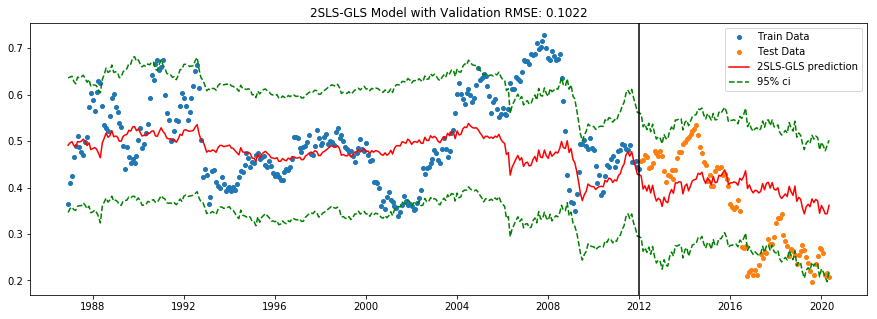

In [56]:
y_pre_train_2sls_gls=res_2sls_gls.predict(X_iv_train)
y_pre_test_2sls_gls=res_2sls_gls.predict(X_iv_test)
rmse_m_2sls_gls=evl.rmse(y_train, y_pre_train_2sls_gls)
res_2sls_gls.mrmse = rmse_m_2sls_gls
rmse_p_2sls_gls=evl.rmse(y_test, y_pre_test_2sls_gls)
res_2sls_gls.prmse = rmse_p_2sls_gls
frame_2sls_gls=res_2sls_gls.get_prediction(np.vstack((X_iv_train,X_iv_test))).summary_frame(alpha=0.05)
plt.figure(figsize=[15,5])
plt.plot(t_train, y_train, 'o', markersize=4, label="Train Data")
plt.plot(t_test, y_test, 'o', markersize=4, label="Test Data")
plt.plot(np.hstack((t_train, t_test)),np.hstack((y_pre_train_2sls_gls, y_pre_test_2sls_gls)), 'r', label="2SLS-GLS prediction")
plt.plot(t, frame_2sls_gls.obs_ci_upper, 'g--',label='95% ci')
plt.plot(t, frame_2sls_gls.obs_ci_lower, 'g--',label='_nolegend_')
plt.axvline('2012-01-01',color='k')
plt.legend(loc="best")
plt.title('2SLS-GLS Model with Validation RMSE: %.4f'%rmse_p_2sls_gls)
plt.show()

In [57]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}",
           'Robust' : lambda x: f"{x.cov_type}",
           'Model RMSE' : lambda x: f"{x.mrmse:.4f}",
           'Validation RMSE' : lambda x: f"{x.prmse:.4f}"}
results_table = summary_col(results=[res_ols,res_glsar,res_gls,res_wls,res_robust_ols,res_2sls,res_2sls_gls],
                            float_format='%.2e',
                            stars = True,
                            model_names=['OLS',
                                         'GLSAR',
                                         'GLS',
                                         'WLS',
                                         'Robust OLS',
                                         '2SLS',
                                         '2SLS-GLS'],
                            info_dict=info_dict,
                            regressor_order=['log_m0',
                                             'log_y',
                                             'r_sb',
                                             'pi_e_lb',
                                             'tb_us',
                                             'tb_us_hat',
                                             'tb_uk'])

results_table.add_title('Table 1 - Structural Model Regressions')

print(results_table)

                                  Table 1 - Structural Model Regressions
                     OLS         GLSAR         GLS          WLS       Robust OLS      2SLS       2SLS-GLS  
-----------------------------------------------------------------------------------------------------------
log_m0           6.40e-02***  1.06e-01***  1.34e-01***  6.34e-02***  6.40e-02***  6.63e-02***  1.30e-01*** 
                 (1.01e-02)   (1.58e-02)   (1.08e-02)   (1.02e-02)   (1.01e-02)   (1.02e-02)   (1.93e-02)  
log_y            -4.61e-01*** -2.53e-01**  -1.24e-01    -4.64e-01*** -4.61e-01*** -4.51e-01*** -1.70e-01   
                 (8.03e-02)   (1.29e-01)   (9.40e-02)   (8.06e-02)   (7.91e-02)   (8.15e-02)   (1.54e-01)  
r_sb             -2.43e+00*** -1.13e+00**  -1.37e+00*** -2.45e+00*** -2.43e+00*** -2.50e+00*** -1.47e+00*  
                 (3.59e-01)   (4.62e-01)   (4.57e-01)   (3.65e-01)   (3.09e-01)   (3.61e-01)   (8.55e-01)  
pi_e_lb          9.66e-01     7.39e-01     9.44e-01     1.03e+0

## 3. ARIMA Model Selection

### 3.1 Stationary Check

In [58]:
ts=df[['s_us_uk']]
ts.index.rename('month',inplace=True)
#ts.index=pd.date_range(start='1986-12-01',end='2020-05-01',freq='MS')
ts.head()

,s_us_uk
month,
1986-12-01,1.4393
1987-01-01,1.5054
1987-02-01,1.5280
1987-03-01,1.5923
1987-04-01,1.6313


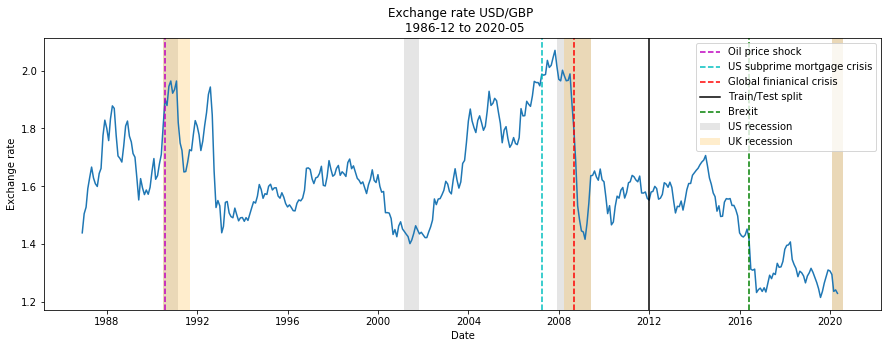

In [59]:
plt.figure(figsize=[15,5])
plt.xlabel('Date')
plt.ylabel('Exchange rate')
plt.plot(ts)
plt.title('Exchange rate USD/GBP \n 1986-12 to 2020-05')
plt.axvline('1990-08-01',color='m',ls='--',label='Oil price shock')
plt.axvline('2007-04-01',color='c',ls='--',label='US subprime mortgage crisis')
plt.axvline('2008-09-01',color='r',ls='--',label='Global finianical crisis')
plt.axvline('2012-01-01',color='k',label='Train/Test split')
plt.axvline('2016-06-01',color='g',ls='--',label='Brexit')
plt.axvspan('1990-07-01', '1991-03-01', color='gray', alpha=0.2, lw=0,label='US recession')
plt.axvspan('2001-03-01', '2001-11-01', color='gray', alpha=0.2, lw=0)
plt.axvspan('2007-12-01', '2009-06-01', color='gray', alpha=0.2, lw=0)
plt.axvspan('2020-02-01', '2020-08-01', color='gray', alpha=0.2, lw=0)
plt.axvspan('1990-07-01', '1991-09-01', color='orange', alpha=0.2, lw=0,label='UK recession')
plt.axvspan('2008-04-01', '2009-06-01', color='orange', alpha=0.2, lw=0)
plt.axvspan('2020-02-01', '2020-08-01', color='orange', alpha=0.2, lw=0)
plt.legend(loc="upper right")
plt.show()

In [60]:
ts_train=ts.iloc[:302]
ts_test=ts.iloc[302:]

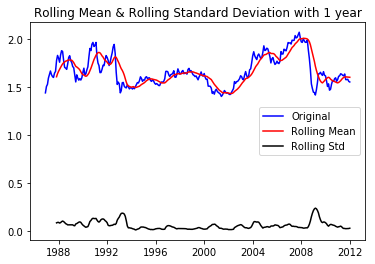

In [61]:
rolling_mean = ts_train.rolling(window = 12).mean()
rolling_std = ts_train.rolling(window = 12).std()
plt.plot(ts_train, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation with 1 year')
plt.show()

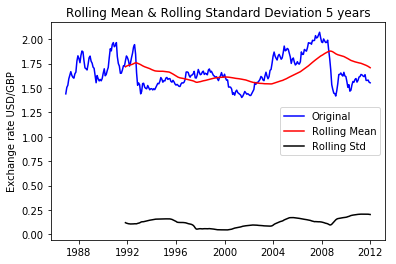

In [62]:
rolling_mean = ts_train.rolling(window = 60).mean()
rolling_std = ts_train.rolling(window = 60).std()
plt.plot(ts_train, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.ylabel('Exchange rate USD/GBP')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation 5 years')
plt.show()

In [63]:
result = adfuller(ts_train['s_us_uk'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.198651656691196
p-value: 0.020062859403078847
Critical Values:
	1%: -3.4524859843440754
	5%: -2.871288184343229
	10%: -2.571964047565425


### 3.2 Data Transformation 

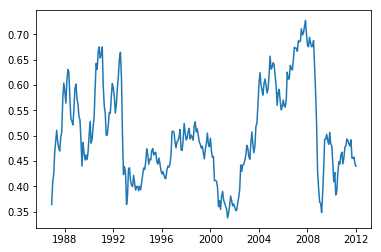

In [64]:
ts_train_log = np.log(ts_train)
plt.plot(ts_train_log)

In [65]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation with 1 year')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['s_us_uk'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

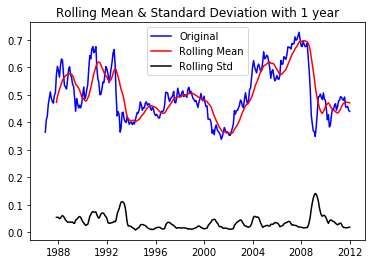

ADF Statistic: -3.20721069016574
p-value: 0.019571071779989534
Critical Values:
	1%: -3.4524859843440754
	5%: -2.871288184343229
	10%: -2.571964047565425


In [66]:
get_stationarity(ts_train_log)

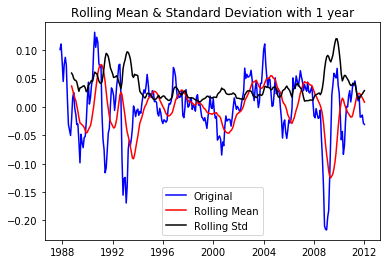

ADF Statistic: -6.165644836947339
p-value: 7.000905124501127e-08
Critical Values:
	1%: -3.453342167806272
	5%: -2.871663828287282
	10%: -2.572164381381345


In [67]:
rolling_mean = ts_train_log.rolling(window=12).mean()
ts_train_log_minus_mean = ts_train_log - rolling_mean
ts_train_log_minus_mean.dropna(inplace=True)
get_stationarity(ts_train_log_minus_mean)

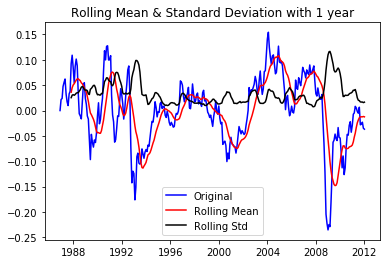

ADF Statistic: -4.182853778516663
p-value: 0.0007043457132968851
Critical Values:
	1%: -3.4524859843440754
	5%: -2.871288184343229
	10%: -2.571964047565425


In [68]:
rolling_mean_exp_decay = ts_train_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
ts_train_log_exp_decay = ts_train_log - rolling_mean_exp_decay
ts_train_log_exp_decay.dropna(inplace=True)
get_stationarity(ts_train_log_exp_decay)

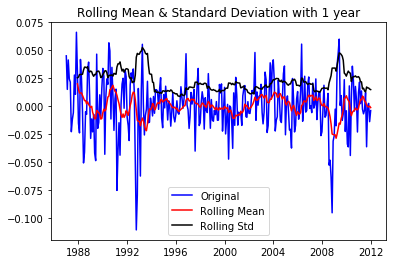

ADF Statistic: -8.692976758217313
p-value: 3.99416177557597e-14
Critical Values:
	1%: -3.4524859843440754
	5%: -2.871288184343229
	10%: -2.571964047565425


In [69]:
ts_train_log_shift = ts_train_log - ts_train_log.shift()
ts_train_log_shift.dropna(inplace=True)
get_stationarity(ts_train_log_shift)

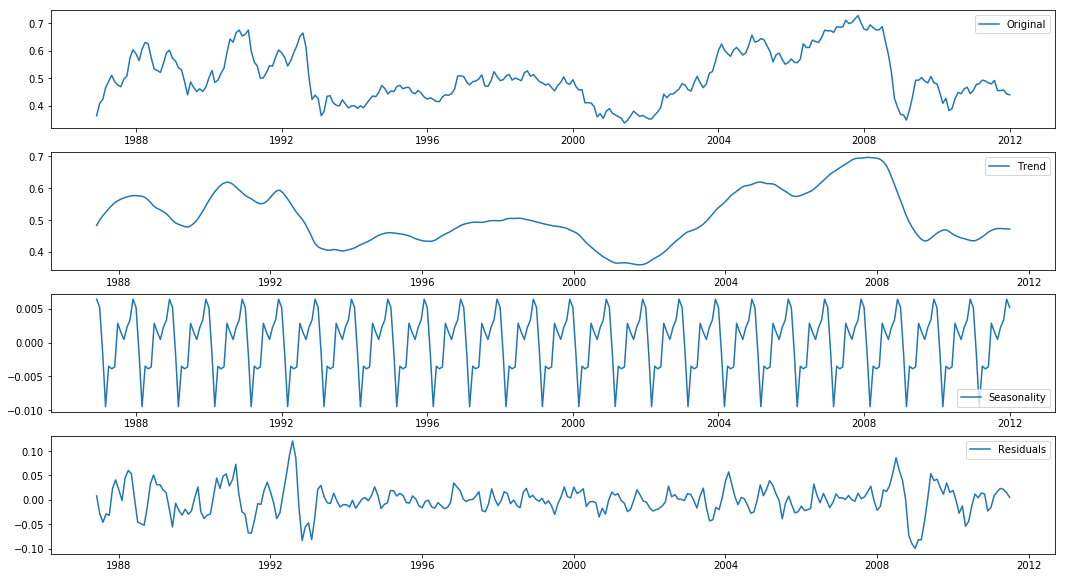

In [70]:
decomposition = seasonal_decompose(ts_train_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual =decomposition.resid

plt.figure(figsize=[18,10])
plt.subplot(411)
plt.plot(ts_train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

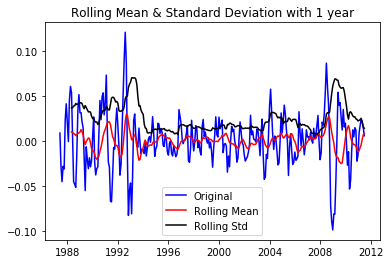

ADF Statistic: -7.81667556547555
p-value: 6.840737433427483e-12
Critical Values:
	1%: -3.453922368485787
	5%: -2.871918329081633
	10%: -2.5723001147959184


In [71]:
ts_train_log_decompose=residual
ts_train_log_decompose.dropna(inplace=True)
get_stationarity(ts_train_log_decompose)

In [72]:
ts_log = np.log(ts)
ts_train_log=ts_log.iloc[:302]
ts_test_log=ts_log.iloc[302:]
ts_log_shift = ts_log - ts_log.shift()
ts_log_shift.dropna(inplace=True)
ts_train_log_shift=ts_log_shift.iloc[:302]
ts_test_log_shift=ts_log_shift.iloc[302:]

### 3.3 ARIMA(p,d,q)

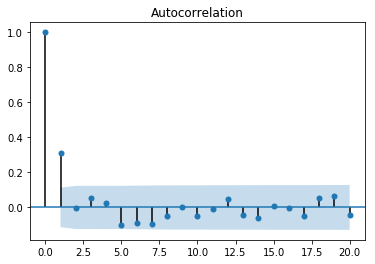

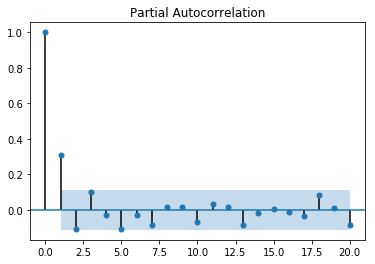

In [73]:
plot_acf(ts_train_log_shift,lags=20)
plot_pacf(ts_train_log_shift,lags=20)
plt.show()

In [74]:
#AR1 Model
model_AR1 = ARIMA(ts_train_log, order=(1,1,0),freq='MS')
results_AR1 = model_AR1.fit(disp=-1,trend='nc')
pre_AR1 = results_AR1.predict('1987-01-01','2020-05-01',typ='levels')
pre_one_train_AR1 = pre_AR1.iloc[:301]
pre_dy_test_AR1 = pre_AR1.iloc[301:]
rmse_m_AR1=evl.rmse(ts_train_log.iloc[1:].s_us_uk, pre_one_train_AR1)
rmse_p_dy_AR1=evl.rmse(ts_test_log.s_us_uk, pre_dy_test_AR1)

mod_AR1=sm.tsa.SARIMAX(ts_train_log, order=(1,1,0),freq='MS')
res_AR1=mod_AR1.fit(trend='nc')
test_one_AR1=sm.tsa.SARIMAX(ts_log.iloc[301:], order=(1,1,0),freq='MS')
res_one_test_AR1=test_one_AR1.smooth(res_AR1.params)
pre_one_test_AR1=res_one_test_AR1.predict('2012-02-01','2020-05-01',typ='levels')
rmse_p_one_AR1=evl.rmse(ts_test_log.s_us_uk, pre_one_test_AR1)

results_AR1.mrmse=rmse_m_AR1                       
results_AR1.pdrmse=rmse_p_dy_AR1
results_AR1.p1rmse=rmse_p_one_AR1

print('ARIMA(1,1,0) with Model (one-step) RMSE: {:.6f}, Validation (one-step) RMSE: {:.6f}, Validation (dynamic) RMSE: {:.6f}'.format(rmse_m_AR1,rmse_p_one_AR1,rmse_p_dy_AR1))

ARIMA(1,1,0) with Model (one-step) RMSE: 0.023371, Validation (one-step) RMSE: 0.019191, Validation (dynamic) RMSE: 0.130787


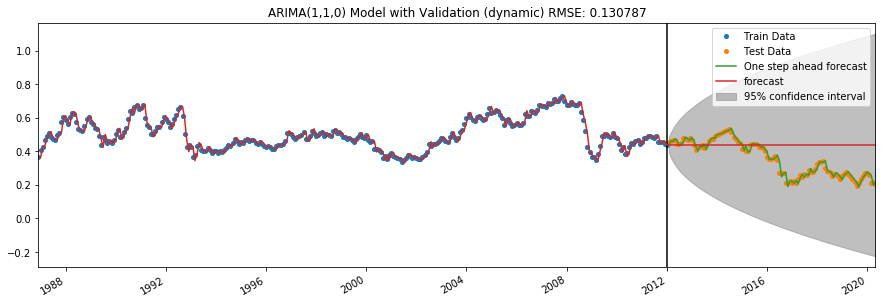

-1403.3357789869879

In [75]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ts_train_log, 'o',markersize=4,label="Train Data")
ax.plot(ts_test_log,'o',markersize=4, label="Test Data")
ax.plot(pre_one_test_AR1,label='One step ahead forecast')
ax.axvline('2012-01-01',color='k')
fig=results_AR1.plot_predict('1987-01-01','2020-05-01',plot_insample=False,ax=ax)
plt.title('ARIMA(1,1,0) Model with Validation (dynamic) RMSE: %.6f'%rmse_p_dy_AR1)
plt.show()
results_AR1.aic

In [76]:
#AR2 Model
model_AR2 = ARIMA(ts_train_log, order=(2,1,0),freq='MS')
results_AR2 = model_AR2.fit(disp=-1,trend='nc')
pre_AR2 = results_AR2.predict('1987-01-01','2020-05-01',typ='levels')
pre_one_train_AR2 = pre_AR2.iloc[:301]
pre_dy_test_AR2 = pre_AR2.iloc[301:]
rmse_m_AR2=evl.rmse(ts_train_log.iloc[1:].s_us_uk, pre_one_train_AR2)
rmse_p_dy_AR2=evl.rmse(ts_test_log.s_us_uk, pre_dy_test_AR2)

mod_AR2=sm.tsa.SARIMAX(ts_train_log, order=(2,1,0),freq='MS')
res_AR2=mod_AR2.fit(trend='nc')
test_one_AR2=sm.tsa.SARIMAX(ts_log.iloc[301:], order=(2,1,0),freq='MS')
res_one_test_AR2=test_one_AR2.smooth(res_AR2.params)
pre_one_test_AR2=res_one_test_AR2.predict('2012-02-01','2020-05-01',typ='levels')
rmse_p_one_AR2=evl.rmse(ts_test_log.s_us_uk, pre_one_test_AR2)

results_AR2.mrmse=rmse_m_AR2                       
results_AR2.pdrmse=rmse_p_dy_AR2
results_AR2.p1rmse=rmse_p_one_AR2

print('ARIMA(2,1,0) with Model (one-step) RMSE: {:.6f}, Validation (one-step) RMSE: {:.6f}, Validation (dynamic) RMSE: {:.6f}'.format(rmse_m_AR2,rmse_p_one_AR2,rmse_p_dy_AR2))

ARIMA(2,1,0) with Model (one-step) RMSE: 0.023233, Validation (one-step) RMSE: 0.019402, Validation (dynamic) RMSE: 0.132388


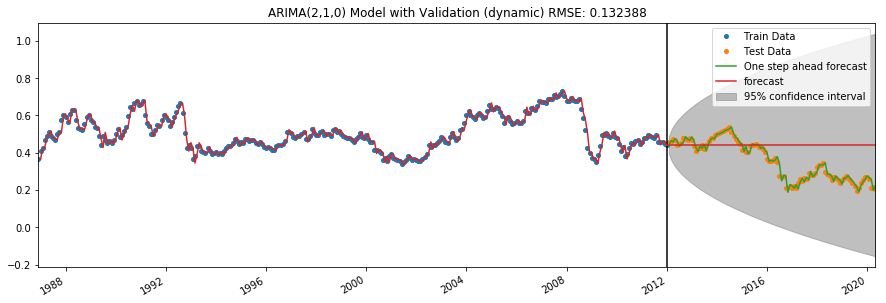

-1404.9186582799307

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ts_train_log, 'o',markersize=4,label="Train Data")
ax.plot(ts_test_log,'o',markersize=4, label="Test Data")
ax.plot(pre_one_test_AR2,label='One step ahead forecast')
ax.axvline('2012-01-01',color='k')
fig=results_AR2.plot_predict('1987-01-01','2020-05-01',plot_insample=False,ax=ax)
plt.title('ARIMA(2,1,0) Model with Validation (dynamic) RMSE: %.6f'%rmse_p_dy_AR2)
plt.show()
results_AR2.aic

In [78]:
# MA1 Model
model_MA1 = ARIMA(ts_train_log, order=(0,1,1),freq='MS')
results_MA1 = model_MA1.fit(disp=-1,trend='nc')
pre_MA1 = results_MA1.predict('1987-01-01','2020-05-01',typ='levels')
pre_one_train_MA1 = pre_MA1.iloc[:301]
pre_dy_test_MA1 = pre_MA1.iloc[301:]
rmse_m_MA1=evl.rmse(ts_train_log.iloc[1:].s_us_uk, pre_one_train_MA1)
rmse_p_dy_MA1=evl.rmse(ts_test_log.s_us_uk, pre_dy_test_MA1)

mod_MA1=sm.tsa.SARIMAX(ts_train_log, order=(0,1,1),freq='MS')
res_MA1=mod_MA1.fit(trend='nc')
test_one_MA1=sm.tsa.SARIMAX(ts_log.iloc[301:], order=(0,1,1),freq='MS')
res_one_test_MA1=test_one_MA1.smooth(res_MA1.params)
pre_one_test_MA1=res_one_test_MA1.predict('2012-02-01','2020-05-01',typ='levels')
rmse_p_one_MA1=evl.rmse(ts_test_log.s_us_uk, pre_one_test_MA1)

results_MA1.mrmse=rmse_m_MA1                       
results_MA1.pdrmse=rmse_p_dy_MA1
results_MA1.p1rmse=rmse_p_one_MA1

print('ARIMA(0,1,1) with Model (one-step) RMSE: {:.6f}, Validation (one-step) RMSE: {:.6f}, Validation (dynamic) RMSE: {:.6f}'.format(rmse_m_MA1,rmse_p_one_MA1,rmse_p_dy_MA1))

ARIMA(0,1,1) with Model (one-step) RMSE: 0.023164, Validation (one-step) RMSE: 0.019419, Validation (dynamic) RMSE: 0.132079


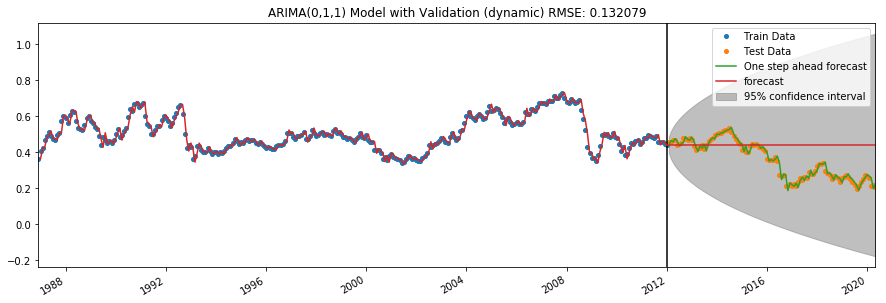

-1408.7386458948745

In [79]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ts_train_log, 'o',markersize=4,label="Train Data")
ax.plot(ts_test_log,'o',markersize=4, label="Test Data")
ax.plot(pre_one_test_MA1,label='One step ahead forecast')
ax.axvline('2012-01-01',color='k')
fig=results_MA1.plot_predict('1987-01-01','2020-05-01',plot_insample=False,ax=ax)
plt.title('ARIMA(0,1,1) Model with Validation (dynamic) RMSE: %.6f'%rmse_p_dy_MA1)
plt.show()
results_MA1.aic

In [80]:
#ARIMA(1,1,1) Model
model_AR1MA1 = ARIMA(ts_train_log, order=(1,1,1),freq='MS')
results_AR1MA1 = model_AR1MA1.fit(disp=-1,trend='nc')
pre_AR1MA1 = results_AR1MA1.predict('1987-01-01','2020-05-01',typ='levels')
pre_one_train_AR1MA1 = pre_AR1MA1.iloc[:301]
pre_dy_test_AR1MA1 = pre_AR1MA1.iloc[301:]
rmse_m_AR1MA1=evl.rmse(ts_train_log.iloc[1:].s_us_uk, pre_one_train_AR1MA1)
rmse_p_dy_AR1MA1=evl.rmse(ts_test_log.s_us_uk, pre_dy_test_AR1MA1)

mod_AR1MA1=sm.tsa.SARIMAX(ts_train_log, order=(1,1,1),freq='MS')
res_AR1MA1=mod_AR1MA1.fit(trend='nc')
test_one_AR1MA1=sm.tsa.SARIMAX(ts_log.iloc[301:], order=(1,1,1),freq='MS')
res_one_test_AR1MA1=test_one_AR1MA1.smooth(res_AR1MA1.params)
pre_one_test_AR1MA1=res_one_test_AR1MA1.predict('2012-02-01','2020-05-01',typ='levels')
rmse_p_one_AR1MA1=evl.rmse(ts_test_log.s_us_uk, pre_one_test_AR1MA1)

results_AR1MA1.mrmse=rmse_m_AR1MA1                       
results_AR1MA1.pdrmse=rmse_p_dy_AR1MA1
results_AR1MA1.p1rmse=rmse_p_one_AR1MA1

print('ARIMA(1,1,1) with Model (one-step) RMSE: {:.6f}, Validation (one-step) RMSE: {:.6f}, Validation (dynamic) RMSE: {:.6f}'.format(rmse_m_AR1MA1,rmse_p_one_AR1MA1,rmse_p_dy_AR1MA1))

ARIMA(1,1,1) with Model (one-step) RMSE: 0.023160, Validation (one-step) RMSE: 0.019400, Validation (dynamic) RMSE: 0.132120


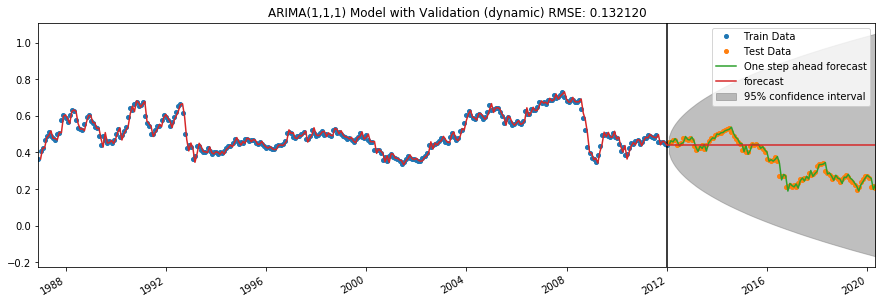

-1406.8369580899148

In [81]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ts_train_log, 'o',markersize=4,label="Train Data")
ax.plot(ts_test_log,'o',markersize=4, label="Test Data")
ax.plot(pre_one_test_AR1MA1,label='One step ahead forecast')
ax.axvline('2012-01-01',color='k')
fig=results_AR1MA1.plot_predict('1987-01-01','2020-05-01',plot_insample=False,ax=ax)
plt.title('ARIMA(1,1,1) Model with Validation (dynamic) RMSE: %.6f'%rmse_p_dy_AR1MA1)
plt.show()
results_AR1MA1.aic

In [82]:
#ARIMA(2,1,1) Model
model_AR2MA1 = ARIMA(ts_train_log, order=(2,1,1),freq='MS')
results_AR2MA1 = model_AR2MA1.fit(disp=-1,trend='nc')
pre_AR2MA1 = results_AR2MA1.predict('1987-01-01','2020-05-01',typ='levels')
pre_one_train_AR2MA1 = pre_AR2MA1.iloc[:301]
pre_dy_test_AR2MA1 = pre_AR2MA1.iloc[301:]
rmse_m_AR2MA1=evl.rmse(ts_train_log.iloc[1:].s_us_uk, pre_one_train_AR2MA1)
rmse_p_dy_AR2MA1=evl.rmse(ts_test_log.s_us_uk, pre_dy_test_AR2MA1)

mod_AR2MA1=sm.tsa.SARIMAX(ts_train_log, order=(2,1,1),freq='MS')
res_AR2MA1=mod_AR2MA1.fit(trend='nc')
test_one_AR2MA1=sm.tsa.SARIMAX(ts_log.iloc[301:], order=(2,1,1),freq='MS')
res_one_test_AR2MA1=test_one_AR2MA1.smooth(res_AR2MA1.params)
pre_one_test_AR2MA1=res_one_test_AR2MA1.predict('2012-02-01','2020-05-01',typ='levels')
rmse_p_one_AR2MA1=evl.rmse(ts_test_log.s_us_uk, pre_one_test_AR2MA1)

results_AR2MA1.mrmse=rmse_m_AR2MA1                       
results_AR2MA1.pdrmse=rmse_p_dy_AR2MA1
results_AR2MA1.p1rmse=rmse_p_one_AR2MA1

print('ARIMA(2,1,1) with Model (one-step) RMSE: {:.6f}, Validation (one-step) RMSE: {:.6f}, Validation (dynamic) RMSE: {:.6f}'.format(rmse_m_AR2MA1,rmse_p_one_AR2MA1,rmse_p_dy_AR2MA1))

ARIMA(2,1,1) with Model (one-step) RMSE: 0.023159, Validation (one-step) RMSE: 0.019210, Validation (dynamic) RMSE: 0.132094


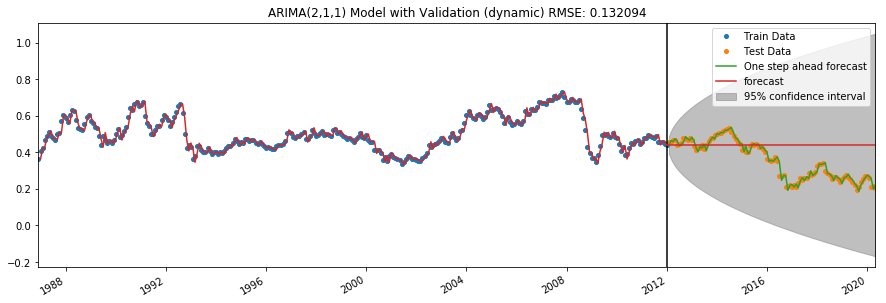

-1404.8379544843328

In [83]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ts_train_log, 'o',markersize=4,label="Train Data")
ax.plot(ts_test_log,'o',markersize=4, label="Test Data")
ax.plot(pre_one_test_AR2MA1,label='One step ahead forecast')
ax.axvline('2012-01-01',color='k')
fig=results_AR2MA1.plot_predict('1987-01-01','2020-05-01',plot_insample=False,ax=ax)
plt.title('ARIMA(2,1,1) Model with Validation (dynamic) RMSE: %.6f'%rmse_p_dy_AR2MA1)
plt.show()
results_AR2MA1.aic

### 3.4 ARIMA Model Comparison

In [84]:
info_dict={'AIC' : lambda x: f"{x.aic:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}",
           'Model (one-step) RMSE' : lambda x: f"{x.mrmse:.6f}",
           'Validation (one-step) RMSE' : lambda x: f"{x.p1rmse:.6f}",
           'Validation (dynamic) RMSE' : lambda x: f"{x.pdrmse:.6f}"}
results_table2 = summary_col(results=[results_AR1,results_AR2,results_MA1,results_AR1MA1,results_AR2MA1],
                            float_format='%.2e',
                            stars = True,
                            model_names=['ARIMA(1,1,0)',
                                         'ARIMA(2,1,0)',
                                         'ARIMA(0,1,1)',
                                         'ARIMA(1,1,1)',
                                         'ARIMA(2,1,1)'],
                            info_dict=info_dict,
                            regressor_order=[])

results_table2.add_title('Table 2 - ARIMA Model Regressions')

print(results_table2)

                             Table 2 - ARIMA Model Regressions
                           ARIMA(1,1,0) ARIMA(2,1,0) ARIMA(0,1,1) ARIMA(1,1,1) ARIMA(2,1,1)
-------------------------------------------------------------------------------------------
ar.L1.D.s_us_uk            3.13e-01***  3.47e-01***               -4.60e-02    -5.22e-02   
                           (5.50e-02)   (5.75e-02)                (1.46e-01)   (2.42e-01)  
ar.L2.D.s_us_uk                         -1.09e-01*                             3.27e-03    
                                        (5.74e-02)                             (1.04e-01)  
ma.L1.D.s_us_uk                                      3.66e-01***  4.06e-01***  4.12e-01*   
                                                     (5.45e-02)   (1.32e-01)   (2.35e-01)  
AIC                        -1403.34     -1404.92     -1408.74     -1406.84     -1404.84    
No. observations           301          301          301          301          301         
Model (one-step) 

## 4. Conclusion

In [85]:
results_MA1.prmse=results_MA1.p1rmse
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'AIC' : lambda x: f"{x.aic:.2f}",
           'Robust' : lambda x: f"{x.cov_type}",
           'No. observations' : lambda x: f"{int(x.nobs):d}",
           'Model RMSE' : lambda x: f"{x.mrmse:.6f}",
           'Validation RMSE' : lambda x: f"{x.prmse:.6f}",
           'Validation (dynamic) RMSE' : lambda x: f"{x.pdrmse:.6f}"}
results_table2 = summary_col(results=[res_2sls_gls,results_MA1],
                            float_format='%.2e',
                            stars = True,
                            model_names=['2SLS-GLS',
                                         'ARIMA(0,1,1)'],
                            info_dict=info_dict,
                            regressor_order=['ma.L1.D.s_us_uk','log_m0','log_y','r_sb','pi_e_lb','tb_us_hat','tb_uk'])

results_table2.add_title('Table 3 - Model Regressions')

print(results_table2)

            Table 3 - Model Regressions
                            2SLS-GLS   ARIMA(0,1,1)
---------------------------------------------------
ma.L1.D.s_us_uk                        3.66e-01*** 
                                       (5.45e-02)  
log_m0                    1.30e-01***              
                          (1.93e-02)               
log_y                     -1.70e-01                
                          (1.54e-01)               
r_sb                      -1.47e+00*               
                          (8.55e-01)               
pi_e_lb                   1.01e+00                 
                          (8.67e-01)               
tb_us_hat                 -1.21e-12***             
                          (3.83e-13)               
tb_uk                     -3.33e-12**              
                          (1.61e-12)               
R-squared                 0.77                     
AIC                       -1307.76     -1408.74    
Robust                  

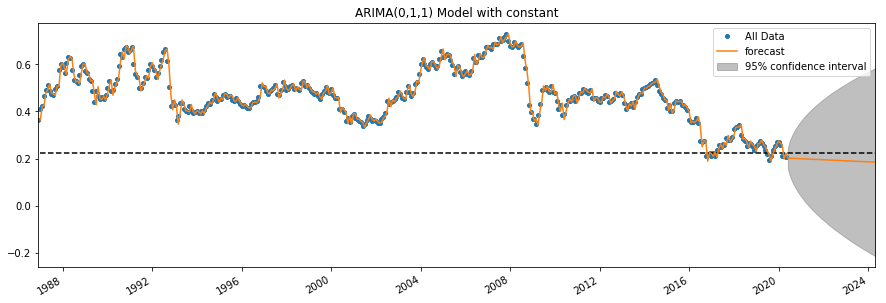

                             ARIMA Model Results                              
Dep. Variable:              D.s_us_uk   No. Observations:                  401
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 956.785
Method:                       css-mle   S.D. of innovations              0.022
Date:                Mon, 31 Aug 2020   AIC                          -1907.570
Time:                        22:30:14   BIC                          -1895.588
Sample:                    01-01-1987   HQIC                         -1902.825
                         - 05-01-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0004      0.001     -0.249      0.803      -0.003       0.003
ma.L1.D.s_us_uk     0.3284      0.049      6.722      0.000       0.233       0.424
                                

In [86]:
model_new = ARIMA(ts_log, order=(0,1,1),freq='MS')
results_new = model_new.fit(disp=-1,trend='c')
indx=pd.date_range(start='1987-01-01',end='2024-05-01',freq='MS')
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ts_log, 'o',markersize=4,label="All Data")
ax.plot(pd.Series([results_new.predict(typ='levels')[-1] for d in indx], index=indx),'--',color='k')
fig=results_new.plot_predict(1,449,plot_insample=False,ax=ax)
plt.title('ARIMA(0,1,1) Model with constant')
plt.show()
print(results_new.summary())

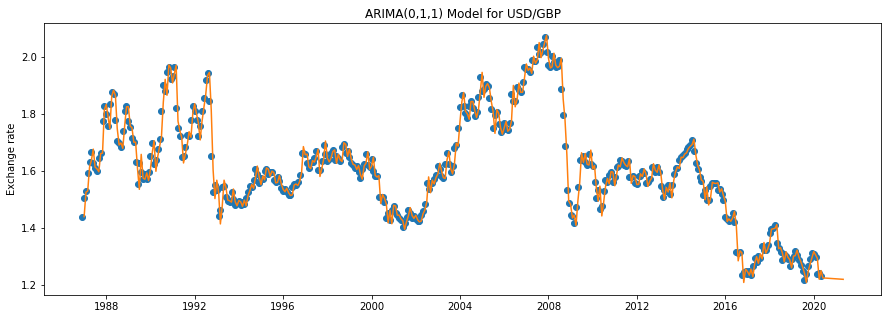

In [87]:
plt.figure(figsize=[15,5])
predict_s=np.exp(results_new.predict(start='1987-01-01',end='2021-05-01',typ='levels'))
plt.plot(df.s_us_uk,'o')
plt.plot(predict_s)
plt.ylabel('Exchange rate')
plt.title('ARIMA(0,1,1) Model for USD/GBP')
plt.show()